2025-01-23 11:37:13.288786: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 11:37:13.344782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-23 11:37:13.344831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-23 11:37:13.346224: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 11:37:13.355530: I tensorflow/core/platform/cpu_feature_guar

Enhanced Grayscale Image - Width: 248, Height: 203
Conv2D Layer - conv2d
  Weights shape: (3, 3, 1, 32)
  Biases shape: (32,)
  First filter weights (shape (3, 3, 1)):
[[[ 0.01510434]
  [ 0.03977798]
  [-0.10623293]]

 [[-0.08803698]
  [-0.10786203]
  [-0.10947567]]

 [[-0.05976152]
  [-0.00805384]
  [ 0.04269306]]]
1/1 [==============================] - 0s 153ms/step
Summed filter image shape: (128, 128)


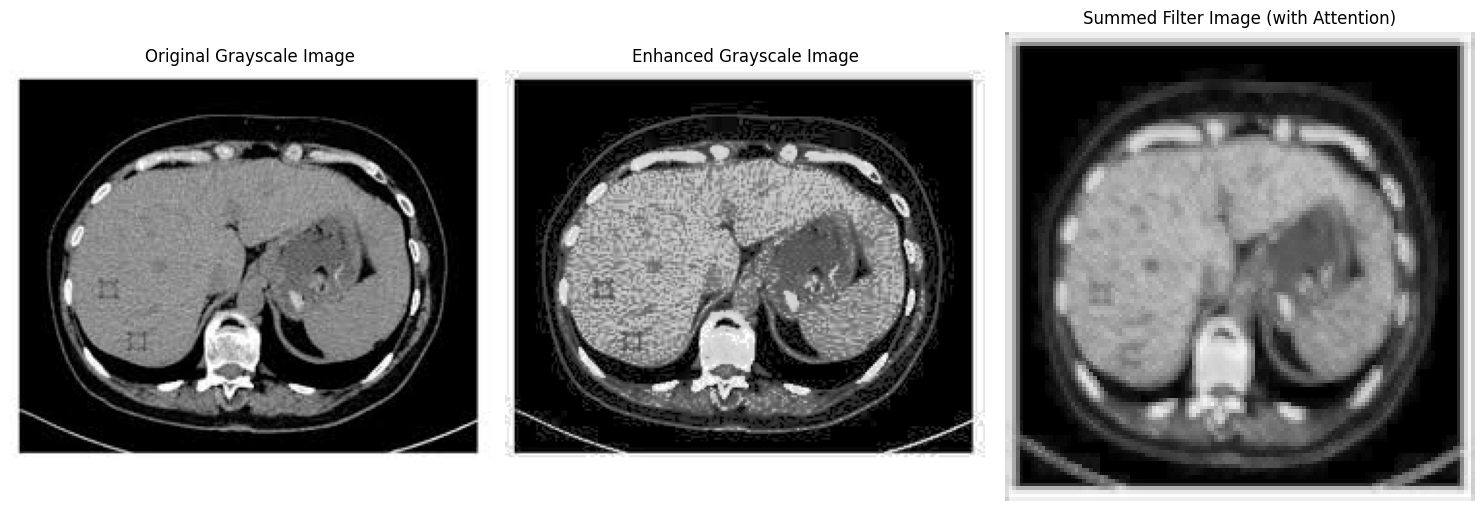

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, Multiply, GlobalAveragePooling2D, Reshape, Dense
import cv2
import tensorflow as tf

# Clear GPU memory and set memory growth to avoid errors
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

# Set TensorFlow to use CPU only to avoid GPU memory errors
tf.config.set_visible_devices([], 'GPU')

# Load the grayscale image
img_path = '/home/icmr/Pictures/CT.jpeg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Enhance the image using histogram equalization
img_enhanced = cv2.equalizeHist(img)

# Check the enhanced image dimensions
height, width = img_enhanced.shape
print(f"Enhanced Grayscale Image - Width: {width}, Height: {height}")

# Resize the image to smaller size (optional step to reduce memory consumption)
resized_img = cv2.resize(img_enhanced, (128, 128))  # Resize to smaller dimensions
resized_height, resized_width = resized_img.shape

# Normalize the resized image (scale pixel values to range [0, 1])
resized_img_normalized = resized_img / 255.0

# Add an extra dimension to represent the batch size (needed for Keras)
# Since the image is grayscale, we only have one channel
img_batch = np.expand_dims(np.expand_dims(resized_img_normalized, axis=-1), axis=0)

# Define the input layer
input_layer = Input(shape=(resized_height, resized_width, 1))

# Apply a single Conv2D layer with 32 filters
conv_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)

# Attention mechanism
# 1. Global Average Pooling to create channel-wise statistics
attention = GlobalAveragePooling2D()(conv_layer)
# 2. Fully connected layers to learn attention weights
attention = Dense(32 // 8, activation='relu')(attention)  # Bottleneck layer
attention = Dense(32, activation='sigmoid')(attention)   # Scale to match channel dimensions
# 3. Reshape and apply attention weights
attention = Reshape((1, 1, 32))(attention)
attention_output = Multiply()([conv_layer, attention])

# Create the model
model = Model(inputs=input_layer, outputs=attention_output)

# Retrieve and print the weights of the Conv2D layer
layer = model.layers[1]
weights, biases = layer.get_weights()
print(f"Conv2D Layer - {layer.name}")
print(f"  Weights shape: {weights.shape}")  # (filter_height, filter_width, input_channels, output_channels)
print(f"  Biases shape: {biases.shape}")    # (output_channels,)

# Example: Print the weights for the first filter
print(f"  First filter weights (shape {weights[:, :, :, 0].shape}):")
print(weights[:, :, :, 0])  # Weights for the first filter

# Get the filtered output from the model (including the attention mechanism)
filtered_img = model.predict(img_batch)

# Remove the batch dimension to get the final image shape
filtered_img = filtered_img[0]

# Sum all the feature maps to create a single summed filter image
summed_filter_img = np.sum(filtered_img, axis=-1)
print(f"Summed filter image shape: {summed_filter_img.shape}")

# Display the original, enhanced, and summed filter images
plt.figure(figsize=(15, 5))

# Original grayscale image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')  # Display as grayscale
plt.title('Original Grayscale Image')
plt.axis('off')

# Enhanced grayscale image
plt.subplot(1, 3, 2)
plt.imshow(img_enhanced, cmap='gray')  # Display enhanced image
plt.title('Enhanced Grayscale Image')
plt.axis('off')

# Summed filter image
plt.subplot(1, 3, 3)
plt.imshow(summed_filter_img, cmap='gray')  # Display summed filter output
plt.title('Summed Filter Image (with Attention)')
plt.axis('off')

plt.tight_layout()
plt.show()
